In [850]:
import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
import seaborn  as sns
import matplotlib.pyplot as plt
import stanza
import re
from html import unescape
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

from transformers import pipeline


In [721]:
plt.style.use('ggplot')

In [144]:
stanza.download('es')

2024-08-08 19:02:12 INFO: Downloaded file to C:\Users\Dell\stanza_resources\resources.json
2024-08-08 19:02:12 INFO: Downloading default packages for language: es (Spanish) ...
2024-08-08 19:02:13 INFO: File exists: C:\Users\Dell\stanza_resources\es\default.zip
2024-08-08 19:02:17 INFO: Finished downloading models and saved to C:\Users\Dell\stanza_resources


In [145]:
nlp=stanza.Pipeline('es')

2024-08-08 19:02:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-08-08 19:02:17 INFO: Downloaded file to C:\Users\Dell\stanza_resources\resources.json
2024-08-08 19:02:19 INFO: Loading these models for language: es (Spanish):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | combined_charlm   |
| depparse     | combined_charlm   |
| sentiment    | tass2020_charlm   |
| ner          | conll02           |

2024-08-08 19:02:19 INFO: Using device: cpu
2024-08-08 19:02:19 INFO: Loading: tokenize
2024-08-08 19:02:19 INFO: Loading: mwt
2024-08-08 19:02:19 INFO: Loading: pos
2024-08-08 19:02:19 INFO: Loading: lemma
2024-08-08 19:02:20 INFO: Loading: constit

In [146]:
#nltk.download('all')

In [213]:
# se define esa función para limiar el texto y eliminar los emojis
def clean_text(x):
  emoji_patron = re.compile("["
                             u"\U0001F600-\U0001F64F"
                             u"\U0001F300-\U0001F5FF"
                             u"\U0001F680-\U0001F6FF"
                             u"\U0001F700-\U0001F77F"
                             u"\U0001F780-\U0001F7FF"
                             u"\U0001F800-\U0001F8FF"
                             u"\U0001F900-\U0001F9FF"
                             u"\U0001FA00-\U0001FA6F"
                             u"\U0001FA70-\U0001FAFF"
                             u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
  x=x.lower()

  x = re.sub(r'<[^>]+>', ' ', x)
  x = unescape(x)
  x = re.sub(r"https?\://\S+",' ', x)
  regex = '[\!\"\#$\%\&\*\+\,\-\.\/\:\;\<\=\>\?\@\^_\`\{\|\}\~]'
  x=re.sub(regex,' ',x)
  x = re.sub(emoji_patron,' ',x)
  x= re.sub(r'\n', ' ', x)
  x = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@/]', ' ', x)
  x = re.sub('\d','', x)
  x = re.sub('\S*@\S*\s?','', x)
  x = re.sub(r'!', '', x)
  x = re.sub(r'\?', '', x)
  return x

## Análisis exploratorio de titulares

In [148]:
df=pd.read_excel("BD - Noticia.xlsx")
df['Fecha']=df['Fecha'].replace('29/3//2019','2019-03-29 00:00:00',regex=True)
df1=df[['Titular','Fecha']]

In [149]:
df1['Fecha']=pd.to_datetime(df1['Fecha'])

C:\Users\Dell\AppData\Local\Temp\ipykernel_10324\3493608275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Fecha']=pd.to_datetime(df1['Fecha'])


In [150]:
df1['Año']=df1['Fecha'].dt.year

In [151]:
df1.head()

,Titular,Fecha,Año
0,Aumentó la protesta social en Colombia,2009-07-14,2009.0
1,Marcha mundial contra Chávez se realizará en m...,2009-09-02,2009.0
2,Comienzan las manifestaciones contra Chávez en...,2009-09-04,2009.0
3,En Colombia y Venezuela se realizaron las prin...,2009-09-03,2009.0
4,Marcha mundial contra Uribe Vélez en Colombia ...,2009-11-07,2009.0


In [851]:
stopwords=stopwords.words('spanish')

In [652]:
stopwords=stopwords+['a', 'al', 'algo','sí','si','bla','mismo','algunas','¿','hacer','x''tener', 'ir','i','¡','``','decir','q','dejar','pago','compra','dar','querer','poder','ven','ser','cada','algunos', 'ante', 'antes', 'como', 'con', 'cual', 'cuando', 'de', 'del',
    'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras',
    'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad','“','”','xd_xd','«','dijo','»','as_com_publicado','según','‘','parte','m','watch'
    'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán',
    'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este',
    'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras',
    'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis',
    'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis',
    'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen',
    'fueses', 'fui', 'fuimos', 'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido',
    'habidos', 'habiendo', 'habremos', 'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais',
    'habríamos', 'habrían', 'habrías', 'habéis', 'había', 'habíais', 'habíamos', 'habían', 'habías', 'han',
    'has', 'hasta', 'hay', 'haya', 'hayamos', 'hayan', 'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera',
    'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese', 'hubieseis', 'hubiesen', 'hubieses', 'hubimos',
    'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'la', 'las', 'le', 'les', 'lo', 'los', 'me',
    'mi', 'mis', 'mucho', 'muchos', 'muy', 'más', 'mí', 'mía', 'mías', 'mío', 'míos', 'nada', 'ni', 'no', 'nos',
    'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros', 'o', 'os', 'otra', 'otras', 'otro',
    'otros', 'para', 'pero', 'poco', 'por', 'porque', 'que', 'quien', 'quienes', 'qué', 'se', 'sea', 'seamos',
    'sean', 'seas', 'sentid', 'sentida', 'sentidas', 'sentido', 'sentidos', 'seremos', 'será', 'serán', 'serás',
    'seré', 'seréis', 'sería', 'seríais', 'seríamos', 'serían', 'serías', 'seáis', 'siente', 'sin', 'sintiendo',
    'sobre', 'sois', 'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'sí', 'también', 'tanto',
    'te', 'tendremos', 'tendrá', ':','tendrán', 'tendrás', 'tendré', 'tendréis', 'tendría', 'tendríais', 'tendríamos',
    'tendrían', 'tendrías', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis',
    'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían',
    'tenías', 'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais',
    'tuvieran', 'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste',
    'tuvisteis', 'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tú', 'un', 'una', 'uno',
    'unos', 'vosotras', 'En','vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos',
        'aca', 'ahí', 'bien', 'chévere', 'chido', 'cuate', 'cómo', 'cuchitril', 'cualquiera', 'dale', 'gracias', 'jaja',
    'jeje', 'mira', 'oye', 'pata', 'pucha', 'pues', 'que', 'qué', 'requete', 'tipo', 'vale', 'wey'
]

In [653]:
#función para remover stopwords de los titulares
remove=lambda x: [word for word in word_tokenize(x) if word not in stopwords]

In [155]:
df1['titular limpio']=df1['Titular'].apply(remove)

In [156]:
def comb(x):
    return ' '.join(x)

In [157]:
df1['titular limpio']=df1['titular limpio'].apply(comb)

In [158]:
def lematizar(texto):
    doc=nlp(texto)
    lemas=[[token.lemma for token in sent.words] for sent in doc.sentences]
    return lemas


In [159]:
df1['titulo lema']=df1['titular limpio'].apply(lematizar)

In [160]:
#df1.to_csv('!parte.csv',index=False)

In [161]:
df1['titulo lema'].iloc[0][0]

['aumentar', 'protesta', 'social', 'Colombia']

In [162]:
df1['titulo lema']=df1['titulo lema'].apply(lambda x: [word for word in word_tokenize(' '.join(x[0][:]))])

In [163]:
df1['titulo lema']=df1['titulo lema'].apply(comb)

In [164]:
df1=df1[['titulo lema','Año']]

In [165]:
df1['Año'].nunique()

16

In [166]:
df1.dropna(subset='Año',inplace=True)

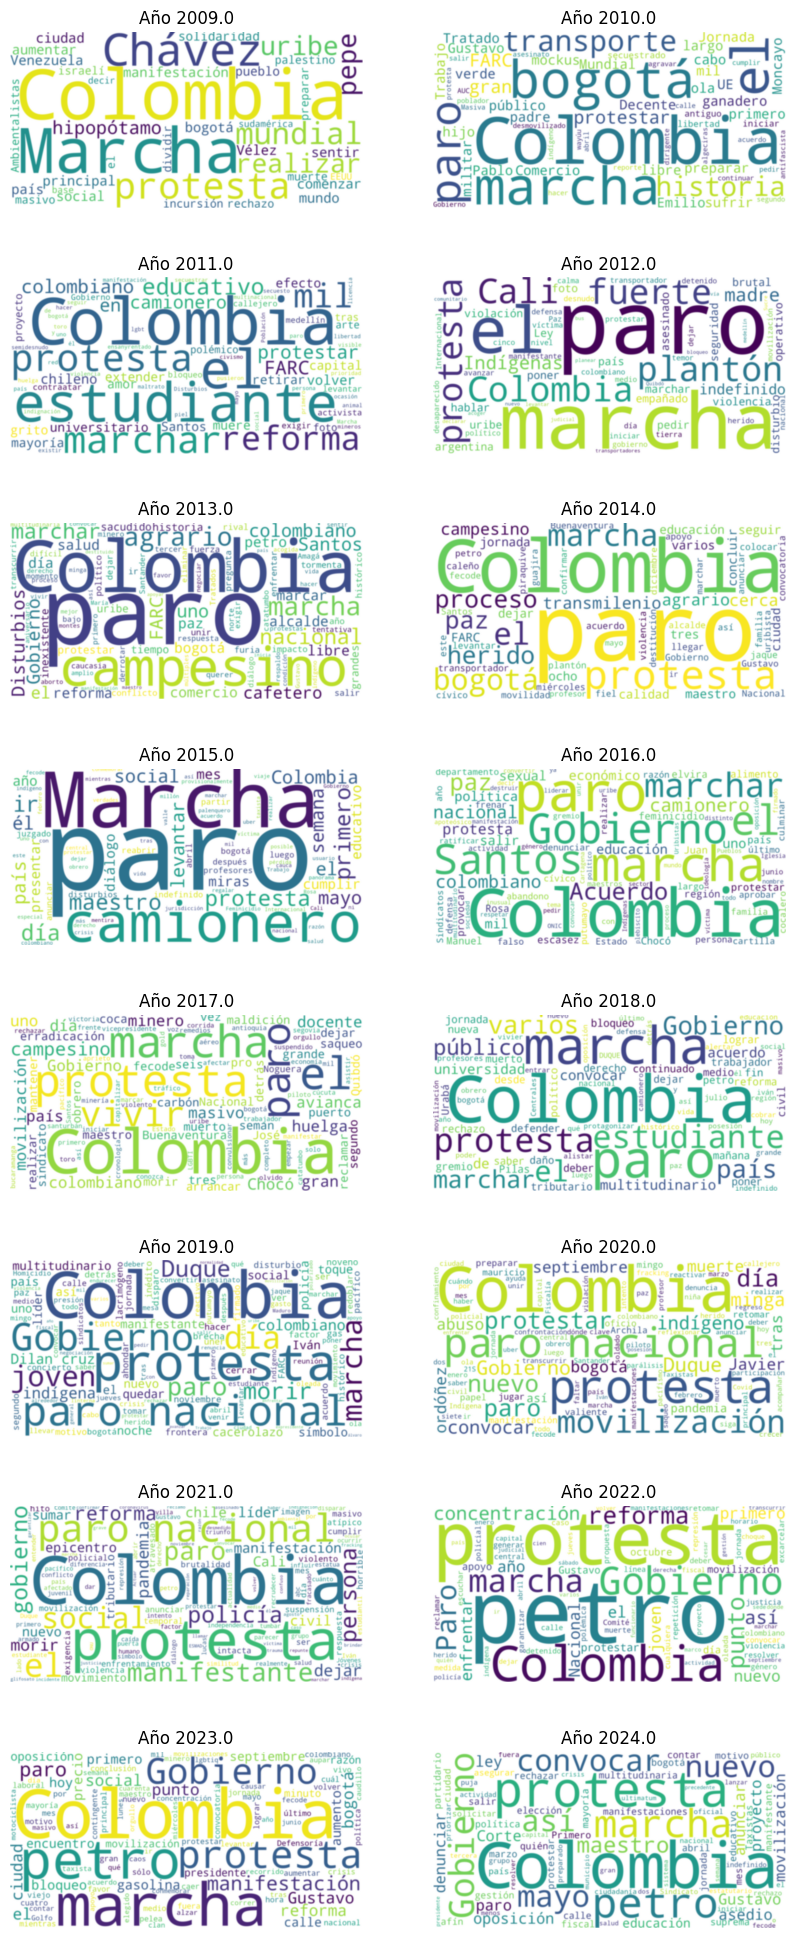

In [167]:
fig,ax=plt.subplots(8,2,figsize=(10,25))
for i,z in zip(range(0,df1['Año'].nunique()),df1['Año'].sort_values().unique().tolist()):
   # print(i,z)
    cloud=WordCloud(width=2000,height=1000,background_color='white').generate(" ".join(df1[df1['Año']==z]['titulo lema'].tolist()))
    #.plot(cloud)
    ax[int(i/2),i%2].imshow(cloud,interpolation='bicubic')
    ax[int(i/2),i%2].set_title(f'Año {z}') 
    ax[int(i/2),i%2].axis('off')
    
plt.show()

## *Descripción de los resultados*.

* En el 2009 los titulares tienen un panorama internacional donde se resaltan las marchas en el mundo contra gobiernos de turno de ese periodo en Venezuela y en Colombia, es decir, en contra de Chávez y Uribe. 

* Los periodos de 2010 y 2021 presentan palabras en común en la mayoría de los titulares, siendo claves las palabras paro y protesta en Colombia, conectadas a distintos reclamos de la población a los gobiernos de turno. Para 2010 la discusión se enfoca en el paro de transportes en Bogotá, en 2011 se resalta la protesta de estudiantes en torno a retirar la reforma del sistema educativo presentada en ese año, entre 2012 y 2014 se habla del paro agrario en Colombia de los campesinos, en 2015 se habla en la mayoría de las titulares del paro camionero, en 2016 se continúa hablando de paro de camioneros, pero, también empieza a tomar relevancia el acuerdo de paz, en 2017 se habla de la protesta de campesinos, del paro minero y el paro en Chocó, en 2018 se habla del paro de estudiantes universitarios, finalmente, entre 2019 y 2021 se habló del paro nacional, protestas y movilizaciones contra el gobierno Duque.

* Entre los periodos de 2022 a 2024 la palabra nueva en común de mayor relevancia es Petro vinculada a gobierno, marcha y protesta. En 2022 se puede entender que se puede hacer alusión al gobierno Petro electo en ese año y la palabra protesta puede estar vinculada a las protestas en octubre de ese año por el alza en los precios de la gasolina y las propuestas de reforma tributaria, pensional y de salud. En 2023 también se presenta un contexto de marchas y protestas vinculadas al precio de la gasolina y a las reformas. Por último, en el presente año también se encuentran presentes las marchas y protesta en el gobierno Petro, resaltándose la oposición y los maestros que se movilizaron contra la reforma a la educación del gobierno. 



# Búsqueda de temas en cada noticia

In [827]:
df2=pd.read_excel("BD_scrap.xlsx")
df2['Fecha']=df2['Fecha'].replace('29/3//2019','2019-03-29 00:00:00',regex=True)
df2['Fecha']=pd.to_datetime(df2['Fecha'])

In [828]:
#Eliminar signos emojis y etiquetas html que puedan estar presentes en el texto
df2['contenido']=df2['contenido'].apply(clean_text)
#Contenido Lematizado
#df2['Cotenido Lematizado']=df2['Contenido SIn STOPWORDS'].apply(lematizar)
#Eliminar Stopwords
remove=lambda x: [word for word in word_tokenize(x) if word not in stopwords]
df2['Contenido NO STOP']=df2['contenido'].apply(remove)
data_lem=df2['Contenido NO STOP'].values.tolist()

In [829]:
data_lem=[[i for i in z if i not in ['“','”','xd_xd','«','dijo','»','as_com_publicado','según','‘','parte','m','watch']] for z in data_lem]

In [830]:
len(data_lem)

321

In [831]:
#Construcción de bigramas
bigram=gensim.models.Phrases(data_lem)
bigram_m=gensim.models.phrases.Phraser(bigram)

In [832]:
def bigr(text,bigram_m):
    return [bigram_m[i] for i in text]
data_lem=bigr(data_lem,bigram_m)

In [833]:
#diccionario
idword=corpora.Dictionary(data_lem)
#identificacion de la frecuencia de palabras
corpus=[idword.doc2bow(text) for text in data_lem]

In [834]:
#identificación de temas individuales por noticia
noticias=[]
for i in range(len(corpus)):
    lda_model=gensim.models.ldamodel.LdaModel(corpus=[corpus[i]],id2word=idword,num_topics=1,passes=50,random_state=123)
    #coherence=CoherenceModel(model=lda_model,texts=data_lem[i],dictionary=idword,coherence='c_v')
    noticias.append({'Temas':" ".join([i for i in re.findall(r'"(.*?)"',lda_model.print_topics(1,25)[0][1]) if i not in ['“','”']])})

d:\User\Escritorio\Linterna Verde\lv-env\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
d:\User\Escritorio\Linterna Verde\lv-env\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: invalid value encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [835]:
temas=pd.DataFrame(noticias)
df_tema=df2.merge(temas,how='inner',left_index=True,right_index=True)[['Fecha','Titular','Temas','Fuente']]
df_tema.head()

,Fecha,Titular,Temas,Fuente
0,2017-10-01,Los colombianos se manifiestan en contra de la...,colombia toros corridas proyecto_ley ley prime...,Agencia Anadolu
1,2020-10-21,Colombia se prepara para un paro nacional con ...,país colombia minga_indígena paro_nacional nue...,Agencia Anadolu
2,2020-06-28,Protestan en Bogotá contra Fiscalía de Colombi...,niña siete_soldados colombia acceso carnal bog...,Agencia Anadolu
3,2021-06-30,"Paro nacional 2021, un hito en la protesta soc...",colombia protestas paro_nacional paro moviliza...,Agencia Anadolu
4,2017-10-12,"Campesinos, obreros y sindicatos realizan marc...",colombia país campesinos sindicatos protestar ...,Agencia Anadolu


In [836]:
df_tema.iloc[70]['Fecha']

Timestamp('2019-11-22 00:00:00')

In [837]:
df_tema.iloc[70]['Titular']

'Protestas en Colombia: disturbios, gas lacrimógeno, cacerolazo, toque de queda y cierre de fronteras'

In [838]:
df_tema.iloc[70]['Temas']

'duque gobierno colombia protestas grupos bogotá cnn colombianos cali grandes noche autoridades atehortua debido reformas lagos personas noviembre toque_queda cacerolazo manifestantes enfrenta indígenas violencia cierres'

In [839]:
#Se idenfica el número de tópicos de mayor coherencia
coherence_score=[]
for i in range(1,20):
    lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=idword,alpha='auto',iterations=100,num_topics=i,passes=40,random_state=123)
    coherence=CoherenceModel(model=lda_model,texts=data_lem,dictionary=idword,coherence='c_v')
    coherence_score.append(coherence.get_coherence())

In [840]:
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=idword,alpha='auto',iterations=100,num_topics=np.argmax(coherence_score),passes=40,random_state=00)

In [841]:
pyLDAvis.enable_notebook()
p=pyLDAvis.gensim.prepare(lda_model,corpus,idword)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.082191  0.061314       1        1  28.649941
2     -0.094776 -0.094286       2        1  15.749388
7     -0.086782 -0.020752       3        1  12.052422
11    -0.069833  0.111087       4        1  10.784275
6     -0.071482  0.034896       5        1  10.262545
9     -0.042244 -0.009275       6        1   6.304501
8     -0.002476 -0.121133       7        1   4.325788
3      0.054117 -0.018541       8        1   3.268558
1      0.078431  0.079186       9        1   2.581591
10     0.127332 -0.035232      10        1   2.119157
5      0.073970 -0.039680      11        1   1.993116
0      0.115936  0.052416      12        1   1.908717, topic_info=                 Term         Freq        Total Category  logprob  loglift
24           colombia  1016.000000  1016.000000  Default  30.0000  30.0000
1295            petro   305.000000   305.000000  Default  29.0000  29.0000
809          maestros   114.000000   114.000000  Default  28.0000  28.0000
66             marcha   392.000000   392.000000  Default  27.0000  27.0000
227         indígenas   154.000000   154.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1123            salud     4.197580   149.123893  Topic12  -6.2761   0.3885
265     paro_nacional     4.028195   163.782001  Topic12  -6.3173   0.2535
761               así     3.791239   168.429827  Topic12  -6.3779   0.1649
2308      estudiantes     3.624151   191.172284  Topic12  -6.4230  -0.0068
237   manifestaciones     3.603526   227.061874  Topic12  -6.4287  -0.1846

[868 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
468        1  0.234417         '
468        2  0.137892         '
468        3  0.124103         '
468        4  0.013789         '
468        5  0.330942         '
...      ...       ...       ...
4656       1  0.396400     áreas
4656      12  0.396400     áreas
12515      8  0.454739     édgar
16000      2  0.962078  –_agosto
17170     10  0.880387         •

[2539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 8, 12, 7, 10, 9, 4, 2, 11, 6, 1])

## *Descripción de los resultados*
Se observa que los principales temas de discusión están relacionados con educación, paz, territorios y derechos humanos. Además, los actores presentes en estas noticas son maestros, estudiantes, indígenas, comunidades, Gustavo Petro, policía y FARC. Lo anterior permite obtener un panorama general, de que durante los 16 años de noticias las discusiones de las movilizaciones sociales se centran en torno la educación y a los derechos humanos de las comunidades, participando en ellas distintos actores que conforman el estado como congresistas, fuerza pública y demás miembros de la población.

In [842]:
#numero de medios
df2['Fuente'].nunique()

81

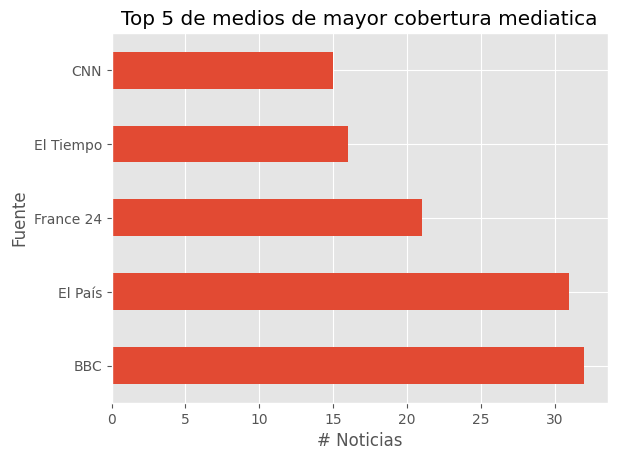

In [843]:
#Top 5 de medio en el cubrimineto de la noticia
ax=df2['Fuente'].value_counts().head(5).plot(kind='barh')
ax.set_xlabel('# Noticias')
ax.set_title('Top 5 de medios de mayor cobertura mediatica')
plt.show()

## *Descripción de los resultados*
De los 81 medios registrados como fuentes, los 5 medios con mayor participación en la cobertura de noticias de la movilización social en Colombia han sido BBC, El País, France24, El tiempo y CNN.

In [844]:
df2.set_index('Fecha',drop=True,inplace=True)

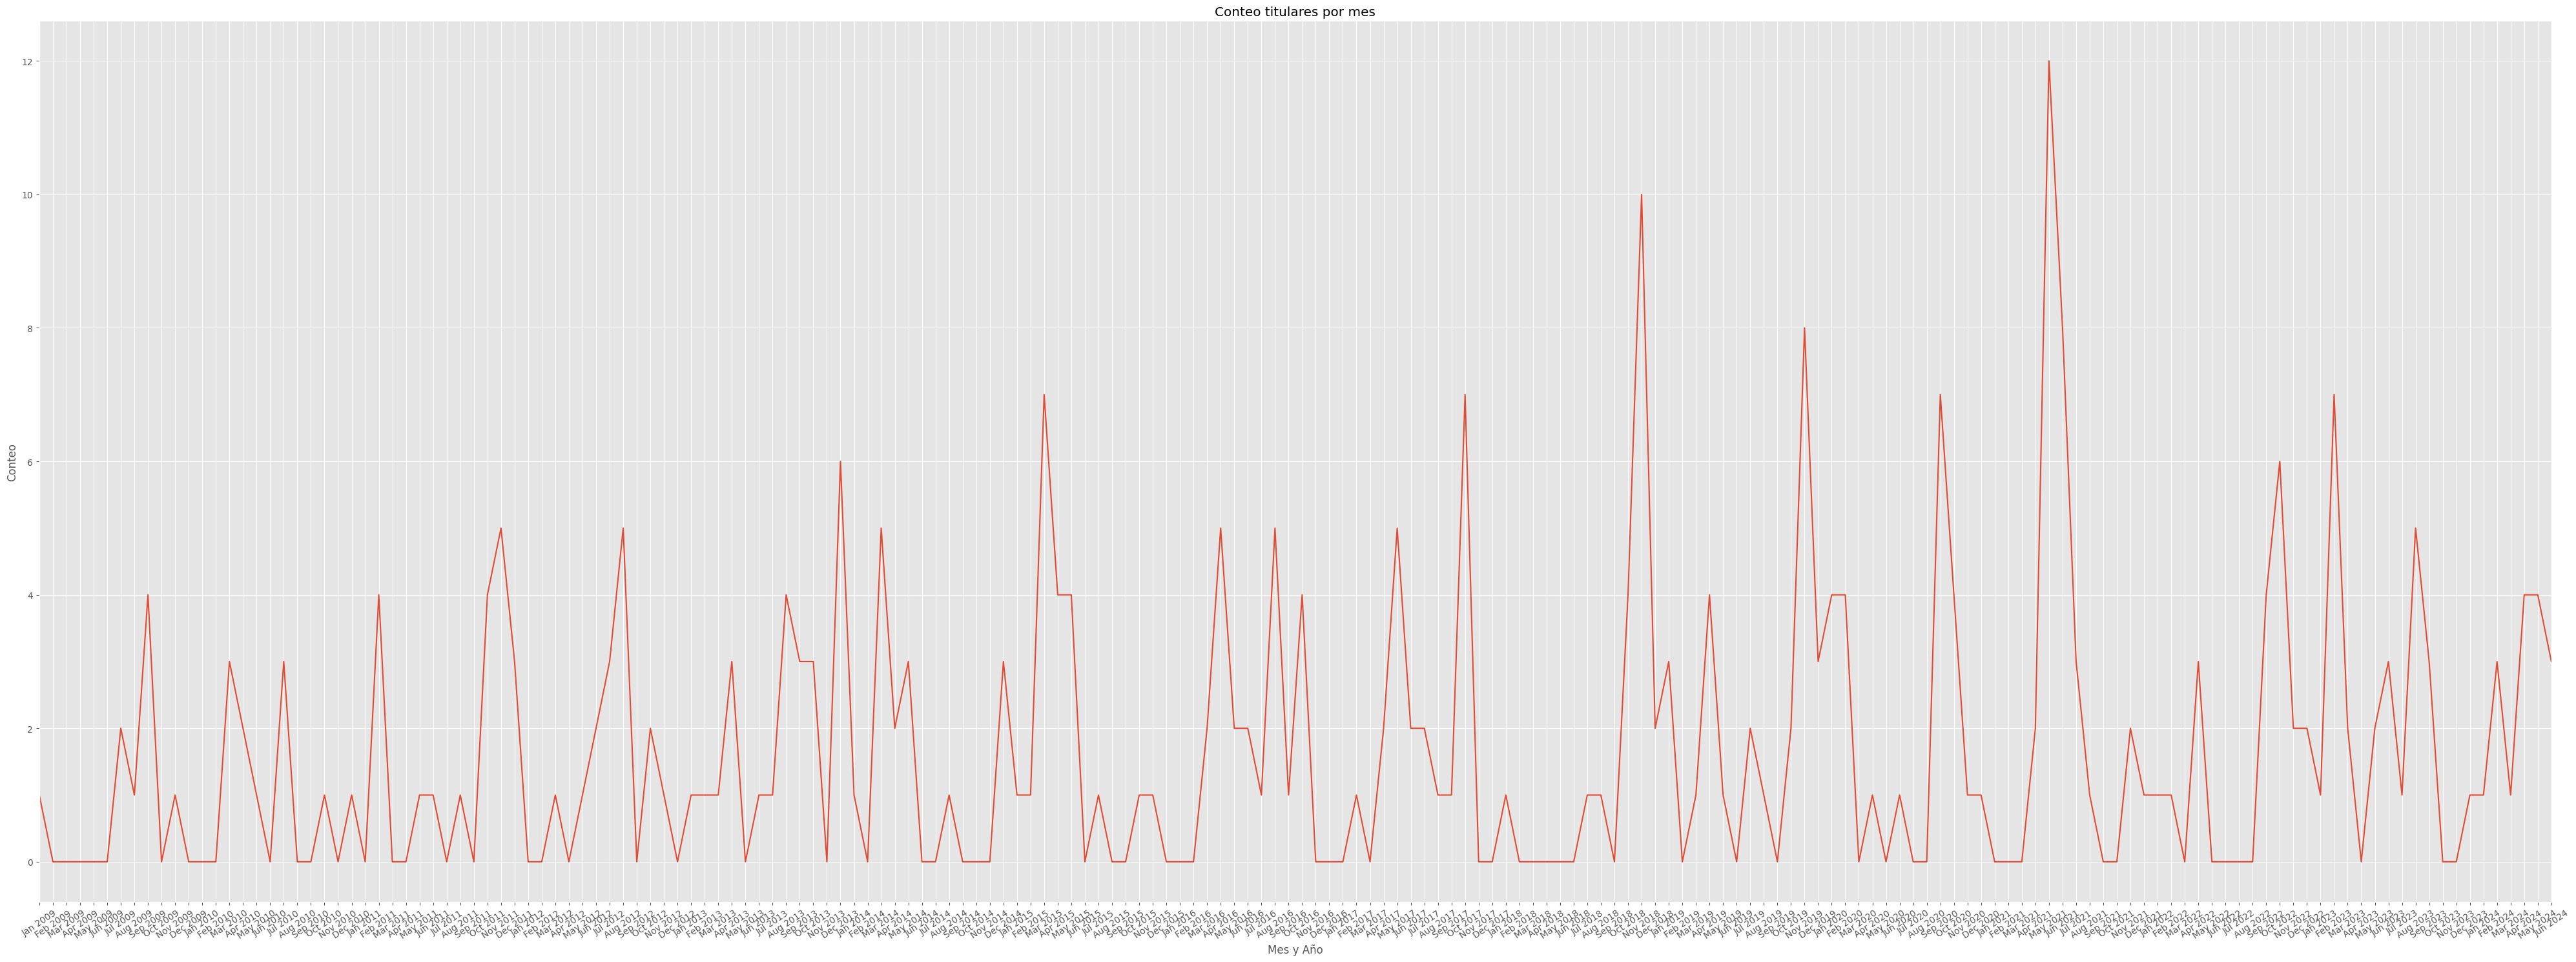

In [845]:
plt.figure(figsize=(40,15))
ax=df2['Titular'].resample('ME').count().plot()
ax.set_xticks(df2['Titular'].resample('ME').count().index)
ax.set_xticklabels(df2['Titular'].resample('ME').count().index.strftime('%b %Y'),rotation=34)
plt.xlabel('Mes y Año')
plt.ylabel('Conteo')
plt.title('Conteo titulares por mes')
plt.tight_layout()
plt.show()



 ## *Descripción de los resultados*

 Abril es un mes con bastante frecuencia de aparición en las noticias de movilizaciones sociales. Esto coincide con el estallido social del 28 de abril de 2021 que se dió en el gobierno Duque tras el anuncio de la reforma tributaria. 

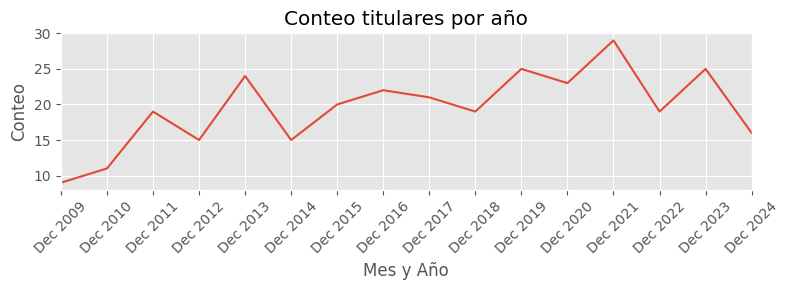

In [846]:
plt.figure(figsize=(8,3))
ax=df2['Titular'].resample('YE').count().plot()
ax.set_xticks(df2['Titular'].resample('YE').count().index)
ax.set_xticklabels(df2['Titular'].resample('YE').count().index.strftime('%b %Y'),rotation=45)
plt.xlabel('Mes y Año')
plt.ylabel('Conteo')
plt.title('Conteo titulares por año')
plt.tight_layout()
plt.show()


 ## *Descripción de los resultados*

En el Gráfico de titulares por año se puede observar de una forma más compacta, que los picos de noticias de movilizaciones social coinciden con los distintos acontecimientos del país. En el 2011 se observa un pico que coincide con la protesta contra la reforma a la educación del gobierno Santos. En 2013 se observa un pico que coincide con el paro agrario. En el 2019 se observa un pico que coincide con el paro nacional en el gobierno Duque. En el 2021 se observa un pico que coincide con el paro nacional tras el anuncio de la reforma tributaria. Finalmente, en el 2023 hay un pico que coincide con las marchas por el aumento al precio de la gasolina y las reformas en el gobierno Petro.

# Movilización social en x

In [1111]:
df3=pd.read_excel("X - Movilizacion.xlsx")
df3.head()

,Date,Time,Author Handle,Hit Sentence
0,2024-04-22,14:05,@petrogustavo,ahorro pensional. Sacan marchas a viejos con p...
1,2024-04-21,18:13,@kimpaim,.co/U4pxmj5l7p ; 🚨| ÚLTIMA HORA: Una vista con...
2,2023-12-01,15:42,@petrogustavo,y los encarceló por miles sino porque los dejó...
3,2023-11-21,08:57,@petrogustavo,Hoy hace 4 años la juventud de Colombia se miv...
4,2023-09-29,16:52,@petrogustavo,internet. Eso no debe volver a suceder en Colo...


In [1112]:
df3.set_index('Date',drop=True,inplace=True)

In [1113]:
#Autores
A2023=df3[df3.index.year==2023]['Author Handle'].nunique()
A2024=df3[df3.index.year==2024]['Author Handle'].nunique()
print(f'Autores en 2023: {A2023}\nAutores en 2024: {A2024}\nVariación: {((A2024/A2023)*100-100):.0f}%')

Autores en 2023: 2946
Autores en 2024: 8505
Variación: 189%


In [1114]:
#Menciones
M2023=df3[(df3.index.year==2023)&(df3['Hit Sentence'].str.contains('@'))].shape[0]
M2024=df3[(df3.index.year==2024)&(df3['Hit Sentence'].str.contains('@'))].shape[0]
print(f'Menciones en 2023: {M2023}\nMenciones en 2024: {M2024}\nVariación: {((M2024/M2023)*100-100):.0f}%')

Menciones en 2023: 2103
Menciones en 2024: 8597
Variación: 309%


In [1115]:
df3['Tipo']=np.where(~df3.duplicated(subset='Hit Sentence'),'Original',\
                    np.where(((df3['Hit Sentence'].str.startswith('@'))&~(df3['Hit Sentence'].str.contains(';'))),'Replies',\
                    np.where((df3['Hit Sentence'].str.startswith('QT')),'Quote Posts',\
                    np.where((df3['Hit Sentence'].str.contains(';',)),'Quote Posts',\
                    np.where((df3['Hit Sentence'].str.startswith(':',)),'Quote Posts','Reposts')))))

In [1116]:
df3['Tipo'].value_counts()

Tipo
Original       17724
Reposts         1699
Quote Posts      516
Replies           61
Name: count, dtype: int64

<Figure size 2000x500 with 0 Axes>

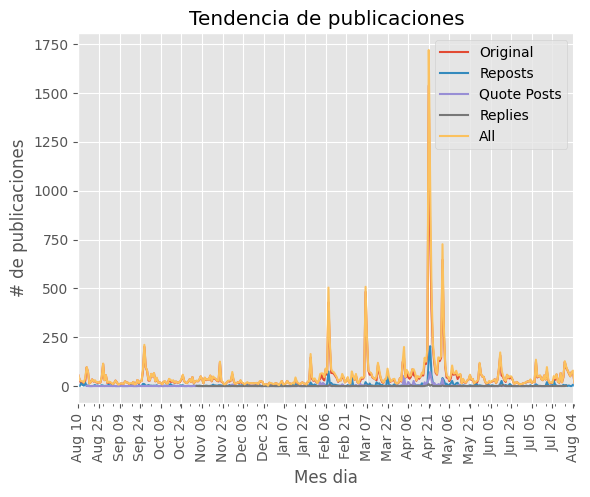

In [1120]:
plt.figure(figsize=(20,5))
ax1=df3[df3['Tipo']=='Original'][['Tipo']].rename(columns={'Tipo':'Original'}).resample('D').count().plot()
ax2=df3[df3['Tipo']=='Reposts'][['Tipo']].rename(columns={'Tipo':'Reposts'}).resample('D').count().plot(ax=ax1)
ax3=df3[df3['Tipo']=='Quote Posts'][['Tipo']].rename(columns={'Tipo':'Quote Posts'}).resample('D').count().plot(ax=ax2)
ax4=df3[df3['Tipo']=='Replies'][['Tipo']].rename(columns={'Tipo':'Replies'}).resample('D').count().plot(ax=ax3)
ax=df3[['Hit Sentence']].rename(columns={'Hit Sentence':'All'}).resample('D').count().plot(ax=ax4)
ax.set_xticks(df3.resample('15D').count().index)
ax.set_xticklabels(df3.resample('15D').count().index.strftime('%b %d'),rotation=90)
plt.xlabel('Mes dia')
plt.ylabel('# de publicaciones')
plt.title('Tendencia de publicaciones')
plt.show()

## *Descripción de los resultados*
Se pueden destacar 4 picos del siguiente gráfico: El primero ubicado en febrero coincide con la marcha promovida por Fecode, el segundo pico en marzo coincide con las marchas en conmemoración del día de la mujer, el tercer pico se ubica en abril coincidiendo con las marchas de la oposición contra las reformas del gobierno Petro y el cuarto en mayo coincide con la marcha de los trabajadores.